In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load sequence IDs and lengths
all_ids = np.loadtxt('Runs/ids_SFE_SE_1.txt', dtype = str)
kmers_mmap = np.load('Runs/kmers_SFE_SE_1.npy', mmap_mode = 'r')
all_lengths = kmers_mmap[:, 0]

# Filter for >= 100 kbp
MIN_LENGTH = 100_000
long_mask = all_lengths >= MIN_LENGTH
filtered_ids = all_ids[long_mask]
filtered_lengths = all_lengths[long_mask]

# Build id -> length mapping
id_to_length = dict(zip(filtered_ids, filtered_lengths))

print(f'Total sequences >= 100 kbp: {len(filtered_ids):,}')
print(f'Length range: {filtered_lengths.min()/1000:.0f} - {filtered_lengths.max()/1000:.0f} kbp')

Total sequences >= 100 kbp: 154,040
Length range: 100 - 10208 kbp


In [3]:
# Parse MCL I=3.0 clusters
cluster_file = 'Runs/MCL_100_NCBI_5_d5/mcl_I3.0.clusters'
clusters = []
with open(cluster_file) as f:
    for line in f:
        members = line.strip().split('\t')
        clusters.append(members)

cluster_sizes = np.array([len(c) for c in clusters])
singletons = [c[0] for c in clusters if len(c) == 1]

print(f'Total clusters: {len(clusters):,}')
print(f'Singletons: {len(singletons):,} ({len(singletons)/len(clusters)*100:.1f}%)')
print(f'Non-singleton clusters: {len(clusters) - len(singletons):,}')
print(f'Total sequences in clusters: {sum(cluster_sizes):,}')

Total clusters: 12,123
Singletons: 710 (5.9%)
Non-singleton clusters: 11,413
Total sequences in clusters: 133,724



Singleton length statistics (kbp):
  Min:    100
  Median: 197
  Mean:   233
  Max:    4104


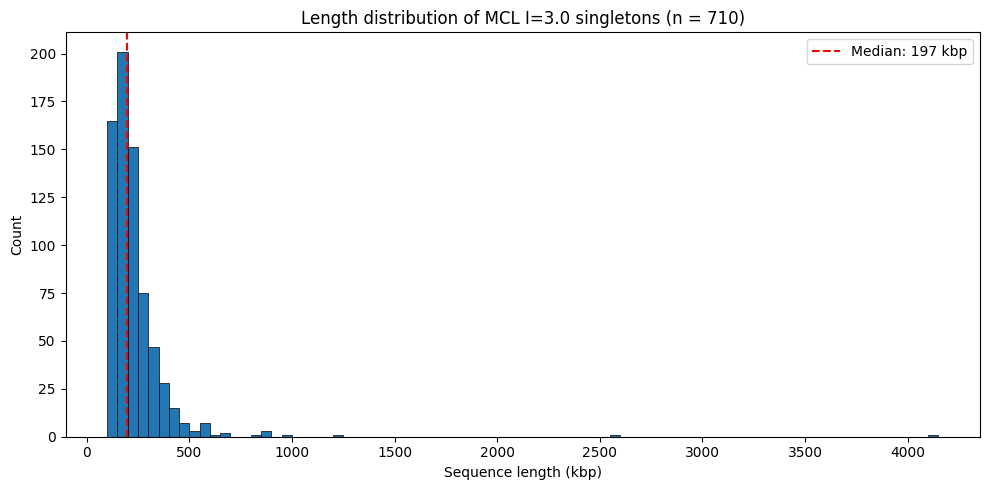

In [4]:
# Get lengths for singletons
singleton_lengths = np.array([id_to_length[s] for s in singletons if s in id_to_length])
missing = len(singletons) - len(singleton_lengths)
if missing:
    print(f'Warning: {missing} singletons not found in id_to_length')

# Also get lengths for all clustered sequences for comparison
all_clustered_lengths = filtered_lengths  # all sequences in the graph

print(f'\nSingleton length statistics (kbp):')
print(f'  Min:    {singleton_lengths.min()/1000:.0f}')
print(f'  Median: {np.median(singleton_lengths)/1000:.0f}')
print(f'  Mean:   {singleton_lengths.mean()/1000:.0f}')
print(f'  Max:    {singleton_lengths.max()/1000:.0f}')

# Plot
fig, ax = plt.subplots(figsize = (10, 5))

bins = np.arange(100, singleton_lengths.max() / 1000 + 50, 50)
ax.hist(singleton_lengths / 1000, bins = bins, edgecolor = 'black', linewidth = 0.5)
ax.set_xlabel('Sequence length (kbp)')
ax.set_ylabel('Count')
ax.set_title(f'Length distribution of MCL I=3.0 singletons (n = {len(singleton_lengths):,})')
ax.axvline(np.median(singleton_lengths) / 1000, color = 'red', linestyle = '--',
           label = f'Median: {np.median(singleton_lengths)/1000:.0f} kbp')
ax.legend()
plt.tight_layout()
plt.show()

In [5]:
# Singletons above 750 kbp
long_singletons = [(s, id_to_length[s]) for s in singletons if id_to_length[s] > 750_000]
long_singletons.sort(key = lambda x: -x[1])
for sid, length in long_singletons:
    print(f'{sid}\t{length/1000:.0f} kbp')

SFE_6_S_c_86643	4104 kbp
SFE_3_S_c_18414	2566 kbp
SFE_2_S_c_44668	1243 kbp
SE_19_c_48401	998 kbp
SE_4_c_88831	894 kbp
SFE_8_S_c_12430	874 kbp
SFE_8_S_c_53232	858 kbp
SFE_3_S_c_3378	812 kbp


In [6]:
# Load NCBI embeddings (embedded through NCBI_5 encoder)
ncbi_embed_all = np.load('Runs/embed_NCBI_5_NCBI_5.npy', mmap_mode = 'r')
ncbi_ids_all = np.loadtxt('Runs/ids_NCBI_5.txt', dtype = str)
ncbi_lengths = ncbi_embed_all[:, 0]
ncbi_mask = ncbi_lengths >= MIN_LENGTH
ncbi_ids = ncbi_ids_all[ncbi_mask]
ncbi_embed = np.array(ncbi_embed_all[ncbi_mask, 1:])  # 384-dim, materialize

# Build set of IDs in the graph (from cluster file) and cluster mapping
graph_ids = set()
id_to_cluster = {}
for ci, c in enumerate(clusters):
    for member in c:
        graph_ids.add(member)
        id_to_cluster[member] = ci

# Find row indices of graph nodes in the full marine ID list
id_to_row = {name: i for i, name in enumerate(all_ids) if name in graph_ids}
graph_rows = np.array(sorted(id_to_row.values()))  # sorted for sequential mmap reads

# Load marine embeddings only for graph nodes (sorted for fast mmap access)
marine_embed_all = np.load('Runs/embed_SFE_SE_1_NCBI_5.npy', mmap_mode = 'r')
marine_graph_embed = np.array(marine_embed_all[graph_rows, 1:])
marine_graph_ids = all_ids[graph_rows]

print(f'NCBI sequences >= 100 kbp: {len(ncbi_ids):,}')
print(f'Marine graph nodes loaded: {len(marine_graph_ids):,}')
print(f'Embedding dim: {ncbi_embed.shape[1]}')

NCBI sequences >= 100 kbp: 175,213
Marine graph nodes loaded: 133,724
Embedding dim: 384


In [7]:
import time

# For each NCBI sequence, find its nearest marine graph node
# Uses ||a-b||^2 = ||a||^2 + ||b||^2 - 2*a@b.T (BLAS-accelerated, all 32 cores)
D_THRESHOLD = 5.0  # same as graph construction
BATCH_SIZE = 10_000

# Precompute squared norms for marine graph embeddings
marine_sq_norms = np.sum(marine_graph_embed ** 2, axis = 1)  # (133K,)

nearest_dist = np.full(len(ncbi_ids), np.inf)
nearest_cluster = np.full(len(ncbi_ids), -1, dtype = int)

t0 = time.time()
for i in range(0, len(ncbi_ids), BATCH_SIZE):
    batch = ncbi_embed[i:i + BATCH_SIZE]
    batch_sq_norms = np.sum(batch ** 2, axis = 1, keepdims = True)  # (batch, 1)
    # Squared Euclidean distances via BLAS matrix multiply
    sq_dists = batch_sq_norms + marine_sq_norms - 2.0 * batch @ marine_graph_embed.T
    np.maximum(sq_dists, 0, out = sq_dists)  # clamp numerical noise
    min_idx = sq_dists.argmin(axis = 1)
    min_sq_dist = sq_dists[np.arange(len(batch)), min_idx]
    nearest_dist[i:i + len(batch)] = np.sqrt(min_sq_dist)
    nearest_cluster[i:i + len(batch)] = [id_to_cluster[marine_graph_ids[j]] for j in min_idx]
    elapsed = time.time() - t0
    done = i + len(batch)
    rate = done / elapsed
    eta = (len(ncbi_ids) - done) / rate
    print(f'  {done:,} / {len(ncbi_ids):,}  ({elapsed:.0f}s elapsed, ~{eta:.0f}s remaining)')

# Apply distance threshold
within_threshold = nearest_dist <= D_THRESHOLD
ncbi_assigned_clusters = set(nearest_cluster[within_threshold])

print(f'\nNCBI sequences with nearest marine neighbor <= d={D_THRESHOLD}: {within_threshold.sum():,} / {len(ncbi_ids):,} ({within_threshold.mean()*100:.1f}%)')
print(f'Clusters with at least one NCBI representative: {len(ncbi_assigned_clusters):,} / {len(clusters):,} ({len(ncbi_assigned_clusters)/len(clusters)*100:.1f}%)')
print(f'Clusters WITHOUT any NCBI representative: {len(clusters) - len(ncbi_assigned_clusters):,}')

  10,000 / 175,213  (2s elapsed, ~27s remaining)
  20,000 / 175,213  (3s elapsed, ~25s remaining)
  30,000 / 175,213  (5s elapsed, ~24s remaining)
  40,000 / 175,213  (7s elapsed, ~22s remaining)
  50,000 / 175,213  (8s elapsed, ~21s remaining)
  60,000 / 175,213  (10s elapsed, ~19s remaining)
  70,000 / 175,213  (12s elapsed, ~18s remaining)
  80,000 / 175,213  (13s elapsed, ~16s remaining)
  90,000 / 175,213  (15s elapsed, ~14s remaining)
  100,000 / 175,213  (17s elapsed, ~13s remaining)
  110,000 / 175,213  (18s elapsed, ~11s remaining)
  120,000 / 175,213  (20s elapsed, ~9s remaining)
  130,000 / 175,213  (22s elapsed, ~8s remaining)
  140,000 / 175,213  (23s elapsed, ~6s remaining)
  150,000 / 175,213  (25s elapsed, ~4s remaining)
  160,000 / 175,213  (27s elapsed, ~3s remaining)
  170,000 / 175,213  (28s elapsed, ~1s remaining)
  175,213 / 175,213  (29s elapsed, ~0s remaining)

NCBI sequences with nearest marine neighbor <= d=5.0: 7,348 / 175,213 (4.2%)
Clusters with at least on

In [8]:
singleton_clusters = {id_to_cluster[s] for s in singletons}
ncbi_singletons = ncbi_assigned_clusters & singleton_clusters
print(f'NCBI-assigned clusters that are singletons: {len(ncbi_singletons)} / {len(ncbi_assigned_clusters)}')

NCBI-assigned clusters that are singletons: 6 / 325


NCBI-matched cluster sizes (n = 325):
  Min:    1
  Median: 21
  Mean:   35
  Max:    158
  Total sequences in these clusters: 11,479


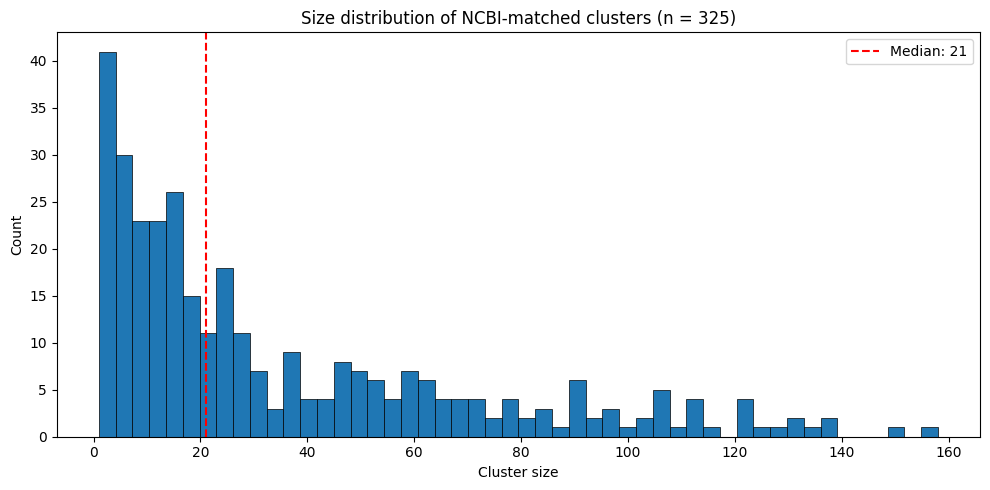

In [9]:
# Cluster size distribution for NCBI-matched clusters
ncbi_cluster_sizes = np.array([cluster_sizes[ci] for ci in ncbi_assigned_clusters])

print(f'NCBI-matched cluster sizes (n = {len(ncbi_cluster_sizes)}):')
print(f'  Min:    {ncbi_cluster_sizes.min()}')
print(f'  Median: {np.median(ncbi_cluster_sizes):.0f}')
print(f'  Mean:   {ncbi_cluster_sizes.mean():.0f}')
print(f'  Max:    {ncbi_cluster_sizes.max()}')
print(f'  Total sequences in these clusters: {ncbi_cluster_sizes.sum():,}')

fig, ax = plt.subplots(figsize = (10, 5))
ax.hist(ncbi_cluster_sizes, bins = 50, edgecolor = 'black', linewidth = 0.5)
ax.set_xlabel('Cluster size')
ax.set_ylabel('Count')
ax.set_title(f'Size distribution of NCBI-matched clusters (n = {len(ncbi_cluster_sizes)})')
ax.axvline(np.median(ncbi_cluster_sizes), color = 'red', linestyle = '--',
           label = f'Median: {np.median(ncbi_cluster_sizes):.0f}')
ax.legend()
plt.tight_layout()
plt.show()

Unmatched cluster sizes (n = 11,798):
  Min:    1
  Median: 3
  Mean:   10
  Max:    180
  Total sequences: 122,245


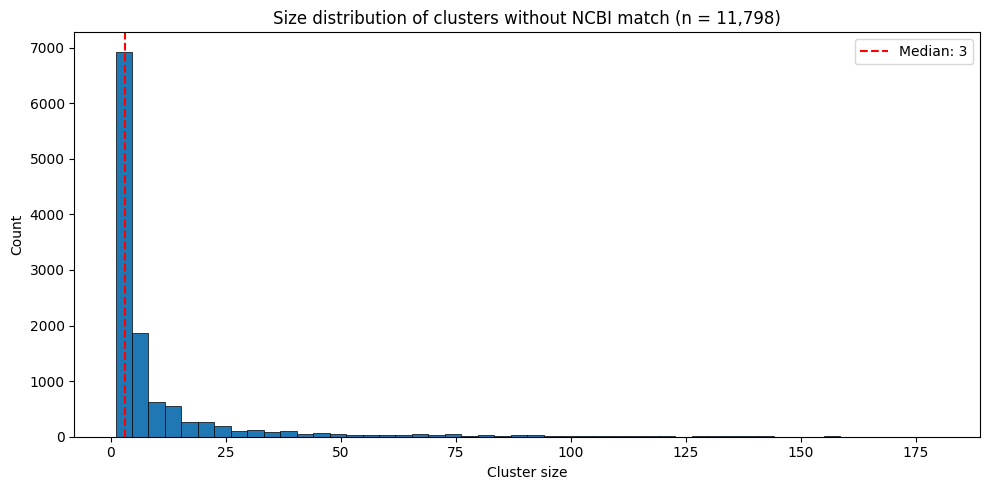

In [10]:
# Size distribution of clusters WITHOUT NCBI match
unmatched = [ci for ci in range(len(clusters)) if ci not in ncbi_assigned_clusters]
unmatched_sizes = np.array([cluster_sizes[ci] for ci in unmatched])

print(f'Unmatched cluster sizes (n = {len(unmatched_sizes):,}):')
print(f'  Min:    {unmatched_sizes.min()}')
print(f'  Median: {np.median(unmatched_sizes):.0f}')
print(f'  Mean:   {unmatched_sizes.mean():.0f}')
print(f'  Max:    {unmatched_sizes.max()}')
print(f'  Total sequences: {unmatched_sizes.sum():,}')

fig, ax = plt.subplots(figsize = (10, 5))
ax.hist(unmatched_sizes, bins = 50, edgecolor = 'black', linewidth = 0.5)
ax.set_xlabel('Cluster size')
ax.set_ylabel('Count')
ax.set_title(f'Size distribution of clusters without NCBI match (n = {len(unmatched_sizes):,})')
ax.axvline(np.median(unmatched_sizes), color = 'red', linestyle = '--',
           label = f'Median: {np.median(unmatched_sizes):.0f}')
ax.legend()
plt.tight_layout()
plt.show()

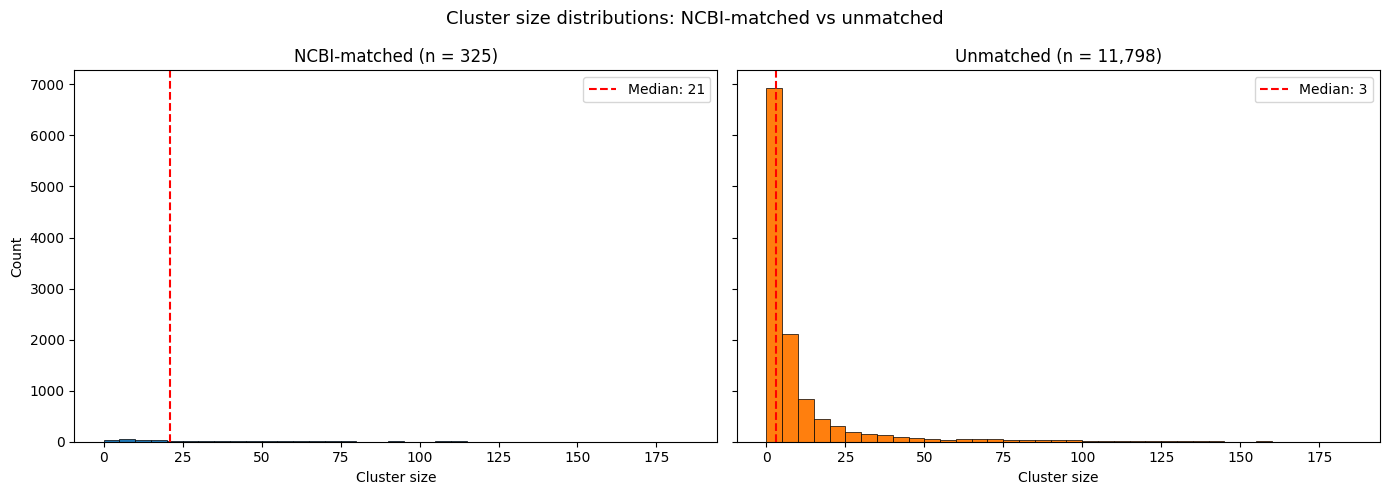

In [11]:
# Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5), sharey = True)

max_size = max(ncbi_cluster_sizes.max(), unmatched_sizes.max())
bins = np.arange(0, max_size + 10, 5)

ax1.hist(ncbi_cluster_sizes, bins = bins, edgecolor = 'black', linewidth = 0.5, color = 'tab:blue')
ax1.axvline(np.median(ncbi_cluster_sizes), color = 'red', linestyle = '--',
            label = f'Median: {np.median(ncbi_cluster_sizes):.0f}')
ax1.set_xlabel('Cluster size')
ax1.set_ylabel('Count')
ax1.set_title(f'NCBI-matched (n = {len(ncbi_cluster_sizes)})')
ax1.legend()

ax2.hist(unmatched_sizes, bins = bins, edgecolor = 'black', linewidth = 0.5, color = 'tab:orange')
ax2.axvline(np.median(unmatched_sizes), color = 'red', linestyle = '--',
            label = f'Median: {np.median(unmatched_sizes):.0f}')
ax2.set_xlabel('Cluster size')
ax2.set_title(f'Unmatched (n = {len(unmatched_sizes):,})')
ax2.legend()

fig.suptitle('Cluster size distributions: NCBI-matched vs unmatched', fontsize = 13)
plt.tight_layout()
plt.show()

In [12]:
# Phase 2: Load NCBI taxonomy and assign consensus taxonomy to clusters
import csv
from collections import defaultdict, Counter

RANKS = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']

# Load taxonomy TSV
ncbi_tax = {}  # ncbi_id -> {rank: name}
with open('Runs/taxonomy/ncbi_taxonomy.tsv') as f:
    reader = csv.DictReader(f, delimiter = '\t')
    for row in reader:
        ncbi_tax[row['ncbi_id']] = {r: row[r] for r in RANKS if row[r]}

print(f'Loaded taxonomy for {len(ncbi_tax):,} NCBI sequences')
print(f'Example: {list(ncbi_tax.items())[0]}')

Loaded taxonomy for 655,640 NCBI sequences
Example: ('NCBI_CP176574', {'domain': 'Bacteria', 'phylum': 'Mycoplasmatota', 'class': 'Mollicutes', 'order': 'Acholeplasmatales', 'family': 'Acholeplasmataceae', 'genus': 'Candidatus Phytoplasma', 'species': 'Candidatus Phytoplasma sacchari'})


In [13]:
# Group NCBI hits by cluster, weighted by distance
# For each cluster: collect all NCBI sequences within d=5.0 with their taxonomy and distance
cluster_ncbi_hits = defaultdict(list)  # cluster_idx -> [(ncbi_id, distance)]

for i in range(len(ncbi_ids)):
    if within_threshold[i]:
        cluster_ncbi_hits[nearest_cluster[i]].append((ncbi_ids[i], nearest_dist[i]))

# Build consensus taxonomy for each matched cluster
cluster_taxonomy = {}  # cluster_idx -> {rank: (name, agreement_fraction, n_hits)}

for ci, hits in cluster_ncbi_hits.items():
    n_hits = len(hits)
    consensus = {}
    for rank in RANKS:
        # Count taxa at this rank across all hits
        taxa = [ncbi_tax.get(nid, {}).get(rank, '') for nid, _ in hits]
        taxa = [t for t in taxa if t]  # remove empty
        if not taxa:
            break  # stop at first rank with no data
        counts = Counter(taxa)
        top_taxon, top_count = counts.most_common(1)[0]
        agreement = top_count / len(taxa)
        consensus[rank] = (top_taxon, agreement, len(taxa))
    cluster_taxonomy[ci] = consensus

# Summary
print(f'Clusters with taxonomy: {len(cluster_taxonomy)}')
n_by_rank = {r: sum(1 for ct in cluster_taxonomy.values() if r in ct) for r in RANKS}
for r in RANKS:
    print(f'  {r:12s}: {n_by_rank[r]:,} clusters')

# Show agreement distribution at phylum level
phylum_agreements = [ct['phylum'][1] for ct in cluster_taxonomy.values() if 'phylum' in ct]
print(f'\nPhylum-level agreement: mean={np.mean(phylum_agreements):.1%}, '
      f'median={np.median(phylum_agreements):.1%}, '
      f'100%={sum(1 for a in phylum_agreements if a == 1.0)}/{len(phylum_agreements)}')

Clusters with taxonomy: 325
  domain      : 325 clusters
  phylum      : 325 clusters
  class       : 324 clusters
  order       : 321 clusters
  family      : 320 clusters
  genus       : 320 clusters
  species     : 320 clusters

Phylum-level agreement: mean=99.9%, median=100.0%, 100%=323/325


In [14]:
# Propagate taxonomy to all marine contigs in matched clusters
# Assign taxonomy at the deepest rank where agreement >= 80%
AGREEMENT_THRESHOLD = 0.8

contig_taxonomy = {}  # marine_id -> {rank: name, ..., 'confidence': tier, 'depth': rank}

for ci, consensus in cluster_taxonomy.items():
    # Find deepest rank with sufficient agreement
    assigned = {}
    deepest_rank = None
    for rank in RANKS:
        if rank not in consensus:
            break
        taxon, agreement, n_hits = consensus[rank]
        if agreement >= AGREEMENT_THRESHOLD:
            assigned[rank] = taxon
            deepest_rank = rank
        else:
            break  # stop at first disagreement

    if not assigned:
        continue

    # Assign to all contigs in this cluster
    for member in clusters[ci]:
        contig_taxonomy[member] = {
            **assigned,
            '_depth': deepest_rank,
            '_cluster': ci,
            '_cluster_size': cluster_sizes[ci],
            '_n_ncbi_hits': len(cluster_ncbi_hits[ci]),
            '_confidence': 'A'  # Tier A: direct NCBI match
        }

# Summary
print(f'Marine contigs with taxonomy (>= {AGREEMENT_THRESHOLD:.0%} agreement):')
print(f'  {len(contig_taxonomy):,} / {sum(cluster_sizes):,} ({len(contig_taxonomy)/sum(cluster_sizes)*100:.1f}%)')
print(f'\nDepth of assignment:')
depth_counts = Counter(v['_depth'] for v in contig_taxonomy.values())
for rank in RANKS:
    if rank in depth_counts:
        print(f'  {rank:12s}: {depth_counts[rank]:,} contigs')

print(f'\nPhylum breakdown:')
phylum_counts = Counter(v.get('phylum', '?') for v in contig_taxonomy.values())
for phylum, count in phylum_counts.most_common(15):
    print(f'  {phylum:30s}: {count:,}')

Marine contigs with taxonomy (>= 80% agreement):
  11,479 / 133,724 (8.6%)

Depth of assignment:
  domain      : 6 contigs
  phylum      : 112 contigs
  class       : 110 contigs
  order       : 640 contigs
  family      : 1,415 contigs
  genus       : 4,039 contigs
  species     : 5,157 contigs

Phylum breakdown:
  Pseudomonadota                : 4,807
  Bacteroidota                  : 3,230
  Actinomycetota                : 834
  Verrucomicrobiota             : 653
  Cyanobacteriota               : 629
  Thermodesulfobacteriota       : 474
  Planctomycetota               : 338
  Nitrososphaerota              : 164
  Kiritimatiellota              : 119
  Spirochaetota                 : 85
  Campylobacterota              : 49
  Chloroflexota                 : 36
  Gemmatimonadota               : 26
  Mycoplasmatota                : 17
  Bacillota                     : 12


In [16]:
# Write taxonomy assignments to TSV
output_file = 'Runs/taxonomy/cluster_taxonomy.tsv'
with open(output_file, 'w') as f:
    header = ['contig_id', 'cluster', 'cluster_size', 'n_ncbi_hits',
              'confidence', 'depth'] + RANKS
    f.write('\t'.join(header) + '\n')
    for contig_id, tax in sorted(contig_taxonomy.items(), key = lambda x: x[1]['_cluster']):
        fields = [
            contig_id,
            str(tax['_cluster']),
            str(tax['_cluster_size']),
            str(tax['_n_ncbi_hits']),
            tax['_confidence'],
            tax['_depth'],
        ]
        for rank in RANKS:
            fields.append(tax.get(rank, ''))
        f.write('\t'.join(fields) + '\n')

print(f'Written {len(contig_taxonomy):,} assignments to {output_file}')

Written 11,479 assignments to Runs/taxonomy/cluster_taxonomy.tsv
